In [1]:
# 
#
# PLOTTING l_CO_bar vs n_H_mean - no evolution
#
#

In [1]:
%matplotlib inline

#import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

In [3]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [3]:
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
K_b_erg = pynbody.array.SimArray(1.38064852e-16, "erg K**-1")
c_si = pynbody.array.SimArray(2.99792458e5, "km s**-1")
c_cgs = pynbody.array.SimArray(2.99792458e10, "cm s**-1")
h_ev = pynbody.array.SimArray(4.13566770e-15, "eV s")
h_erg = pynbody.array.SimArray(6.626196e-27, "erg s")
mH_cgs = pynbody.array.SimArray(1.6737236e-24, 'g')  # hydrogen mass
T_bg = pynbody.array.SimArray(2.73, "K")
eV = pynbody.array.SimArray(6.241509e18, "J")
L_sun = pynbody.array.SimArray(2.43418864387146974e+45, "eV s**-1")
# cell_width = pynbody.array.SimArray(region.gas["smooth"]*3.086e+21, "cm")
M_sun = pynbody.array.SimArray(2e33, "g")

In [4]:
x_1 = 0.4347950859536656
x_0 = 0.25201748686058306
A_10 = pynbody.array.SimArray(7.203e-08, "s**-1")
B_10 = pynbody.array.SimArray(5.10995088e-06, "cm**2 eV**-1 s**-1")
B_01 = pynbody.array.SimArray(1.53298527e-05, "cm**2 eV**-1 s**-1")
nu = pynbody.array.SimArray(1.15271202e+11, "Hz")
mu = 28.0
c_s_CO = np.sqrt(K_b * T_mean/(mH_cgs*mu))

In [5]:
def make_pdf(s, s_bar, sigma_s):
    pdf = (1/np.sqrt(2*np.pi*(sigma_s**2))) * (np.exp(-0.5*(((s - s_bar)/sigma_s)**2)))
    return pdf

def calc_integral(s, pdf, X_H2, ds):
    integ = 0.0
    for i in range(0, 100):
        integ += (np.exp(s[i])*pdf[i]*X_H2[i]*ds)
    return integ

def calc_integral2(s, pdf, X_CO, ds):
    integ = 0.0
    for i in range(0, 100):
        integ += (np.exp(s[i])*pdf[i]*X_CO[i]*ds)
    return integ

def calc_lambda_jeans(n_H, K_b, T, m_p):
    lambda_jeans = (np.sqrt(K_b * T / m_p) / np.sqrt(4* np.pi * G * n_H * m_p))
    return lambda_jeans

def calc_n_LW(n_H, G_o, lambda_jeans, Z):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    n_LW = rad_field_outside * exp_tau
    return n_LW

def calc_n_LW_ss(n_H, n_H2, G_o, lambda_jeans):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2*lambda_jeans
    #N_H2 = N_H2.in_units('1')
    term1 = pynbody.array.SimArray((0.965/((1+(N_H2/5e14))**2)), "1")
    term2 = ( (0.035/np.sqrt(1+(N_H2/5e14))) * np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180) )
    #term1 = term1.in_units('1')
    #term2 = term2.in_units('1')
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return n_LW_ss

def calc_X_H2(n_H, Z, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            #cm3 s-1
    numerator = DC * n_LW
    denominator = CC * Z * n_H
    X_H2 = 1 / (2 + (numerator/denominator) )
    return X_H2

def self_shielding_iterations(n_H, G_o, lambda_jeans, Z):
    X_H2 = np.zeros(100)
    n_LW = np.zeros(100)
    n_H2 = np.zeros(100)
    n_LW_ss = np.zeros(100)
    S_H2_ss = np.zeros(100)
    N_H2_ss = np.zeros(100)
    X_H2_ss = np.zeros(100)
    n_H2_ss = np.zeros(100)
    ctr = 15
    i = 0
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans, Z)
    X_H2 = calc_X_H2(n_H, Z, n_LW)
    n_H2 = n_H * X_H2
    n_H2_ss = n_H2
    while i<ctr:
        #for j in range(100):
        n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, G_o, lambda_jeans)
        X_H2_ss = calc_X_H2(n_H, Z, n_LW_ss)
        n_H2_ss = n_H * X_H2_ss
        i += 1
    return n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2


def calc_X_CO(n_H, n_H2, n_LW):
    rate_CHX = 5.0e-10 * n_LW
    rate_CO = 1.0e-10 * n_LW
    x0 = 2.0e-4
    k0 = 5.0e-16 #cm3 s-1
    k1 = 5.0e-10 #cm3 s-1
    factor_beta = rate_CHX/(n_H*k1*x0)
    beta = 1./(1.+factor_beta)
    factor_CO = rate_CO/(n_H2*k0*beta)
    X_CO = 1./(1.+factor_CO)
    return X_CO

def calc_n_CO(n_H, X_CO, Z):
    abundance_Ctot = 1e-4 # n_C/n_H as defined by nucleosynthesis
    return n_H * abundance_Ctot * Z * X_CO # CO/cc

def tau_LVG(N, nu, lambda_jeans, n_i, n_j, B_ij, B_ji, c_s_CO):
    # units: eV*s * Hz * cm * 1/cm3 * cm2/(eV*s) * 1/(Hz) = none
    delta_nu = c_s_CO*nu/c_cgs #"Hz"
    tau_lvg = h_ev*nu*lambda_jeans*N*((n_j*B_ji)-(n_i*B_ij)) / (4*np.pi*delta_nu)
    return tau_lvg
    
def beta_LVG(tau):
    beta_lvg = np.zeros(len(tau))
    for i in range(0, len(tau)):
        if tau[i] < 0.01:
            beta_lvg[i] = 1. - tau[i]/2.
        elif tau[i] > 100.:
            beta_lvg[i] = 1./tau[i]
        else:
            beta_lvg[i] = (1.0 - np.exp(-tau[i])) / tau[i]
    return beta_lvg

def inside_loop(M, n_H_mean, Z, G_o, K_b, T, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds):
    lambda_jeans = 0 * lambda_jeans
    X_CO = 0 * X_CO
    n_CO = 0 * n_CO
    integral1 = 0.0
    integral2 = 0.0
    n_H = n_H_mean * np.exp(s)
    lambda_jeans = calc_lambda_jeans(n_H, K_b, T, m_p)
    n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2 = self_shielding_iterations(n_H, G_o, lambda_jeans, Z)
    integral1 = calc_integral(s, pdf, X_H2_ss, ds)
    X_H2_bar = 2*integral1
    X_CO = calc_X_CO(n_H, n_H2, n_LW)
    n_CO = calc_n_CO(n_H, X_CO, Z)
    integral2 = calc_integral2(s, pdf, X_CO, ds)
    X_CO_bar = integral2
    
    tau_nu = pynbody.array.SimArray(tau_LVG(n_CO, nu, lambda_jeans, x_1, x_0, B_10, B_01, c_s_CO), "1")
    beta_nu = pynbody.array.SimArray(beta_LVG(tau_nu), "1")
    j_10 = 1.60218e-12*h_ev * nu * n_CO * x_1 * A_10 #erg cm**-3 s**-1
    l_CO = j_10/m_p
    l_CO_prime =  j_10*beta_nu/m_p
    alpha_CO_SI = ((c_cgs/nu)**3)*1e-5*((3.24078e-19)**2)*M_sun/ (2*K_b_erg)
    l_CO_SI = l_CO * alpha_CO_SI
    l_CO_prime_SI = l_CO_prime * alpha_CO_SI

    l_CO_bar = np.sum(l_CO_prime_SI * pdf * ds)
    return X_H2_bar, X_CO_bar, l_CO_bar


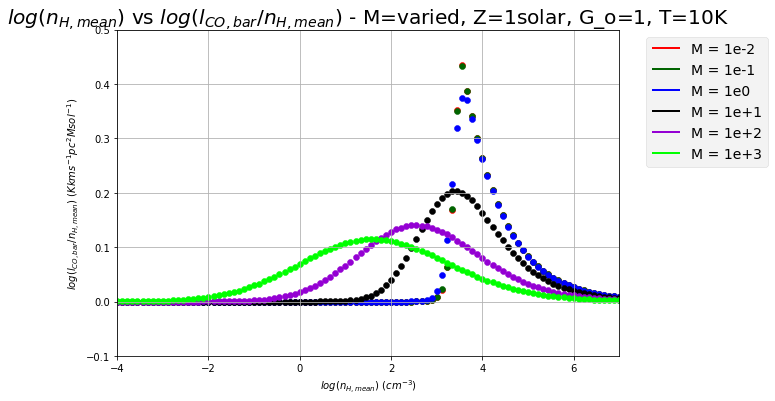

In [6]:
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 1
label = "M "
color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='darkgreen', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='darkviolet', lw=2),
                Line2D([0], [0], color='lime', lw=2)]
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-4, 7, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
l_CO_bar = np.zeros(len(n_H_mean_arr))
n_H2_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    color = str(color_arr[m])
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y], l_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            
            plt.scatter(np.log10(n_H_mean), l_CO_bar[y]/n_H_mean, 
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel('$log(n_{H, mean}) \ (cm^{-3})$')
plt.ylabel('$log(l_{CO, bar}/n_{H, mean}) \ (K km s^{-1} pc^{2} Msol^{-1})$')
ax.set_ylim([-0.1,0.5])
ax.set_xlim([-4, 7])
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H, mean})$ vs $log(l_{CO, bar}/n_{H, mean})$ - M=varied, Z=1solar, G_o=1, T=10K")
plt.savefig('outputs/test_plots/log(n_H_mean)vsl_CO_bar-M.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [7]:
np.shape(n_H_mean_arr)

(100,)

In [8]:
np.shape(X_H2_bar)

(100,)

In [9]:
np.shape(lambda_jeans)

(100,)

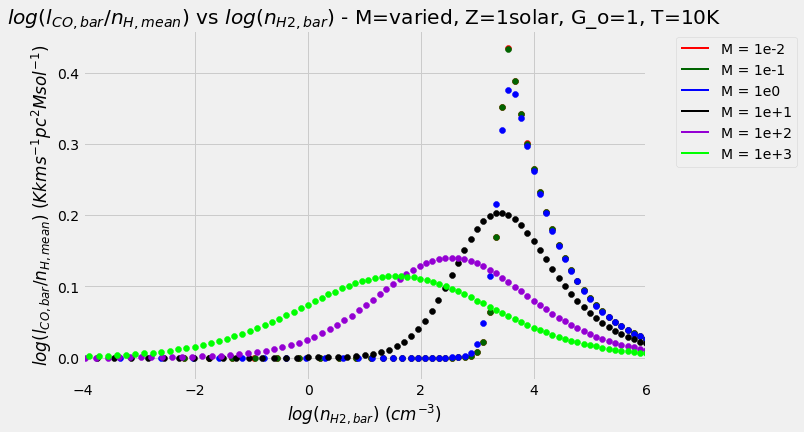

In [56]:
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 1
label = "M "
color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='darkgreen', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='darkviolet', lw=2),
                Line2D([0], [0], color='lime', lw=2)]
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-4, 7, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
l_CO_bar = np.zeros(len(n_H_mean_arr))
n_H2_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    color = str(color_arr[m])
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y], l_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            n_H2_bar[y] = X_H2_bar[y] * n_H_mean
            plt.scatter(np.log10(n_H2_bar[y]), l_CO_bar[y]/n_H_mean,
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.ylabel('$log(l_{CO, bar}/n_{H, mean}) \ (K km s^{-1} pc^{2} Msol^{-1})$')
plt.xlabel('$log(n_{H2, bar}) \ (cm^{-3})$')
# ax.set_ylim([0,0.5])
ax.set_xlim([-4, 6])
plt.grid(b=True, which='both', axis='both')
plt.title("$log(l_{CO, bar}/n_{H, mean})$ vs $log(n_{H2, bar})$ - M=varied, Z=1solar, G_o=1, T=10K")
plt.show()

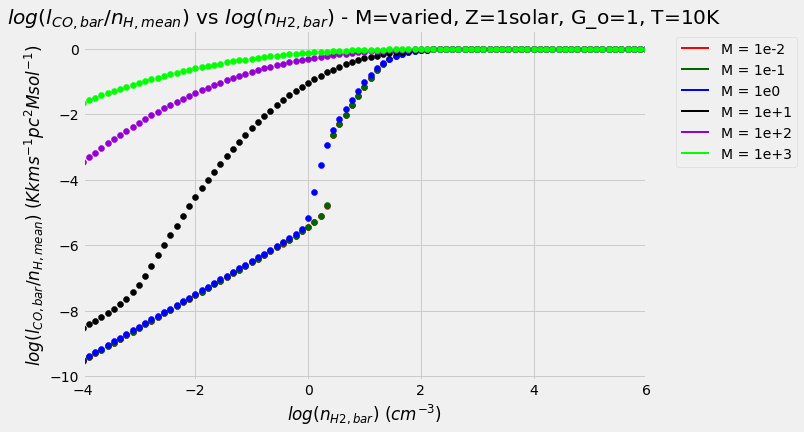

In [55]:
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 1
label = "M "
color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='darkgreen', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='darkviolet', lw=2),
                Line2D([0], [0], color='lime', lw=2)]
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-4, 7, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
l_CO_bar = np.zeros(len(n_H_mean_arr))
n_H2_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    color = str(color_arr[m])
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y], l_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            n_H2_bar[y] = X_H2_bar[y] * n_H_mean
            plt.scatter(np.log10(n_H_mean), np.log10(n_H2_bar[y]/n_H_mean),
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.ylabel('$log(l_{CO, bar}/n_{H, mean}) \ (K km s^{-1} pc^{2} Msol^{-1})$')
plt.xlabel('$log(n_{H2, bar}) \ (cm^{-3})$')
# ax.set_ylim([0,0.5])
ax.set_xlim([-4, 6])
plt.grid(b=True, which='both', axis='both')
plt.title("$log(l_{CO, bar}/n_{H, mean})$ vs $log(n_{H2, bar})$ - M=varied, Z=1solar, G_o=1, T=10K")
plt.show()

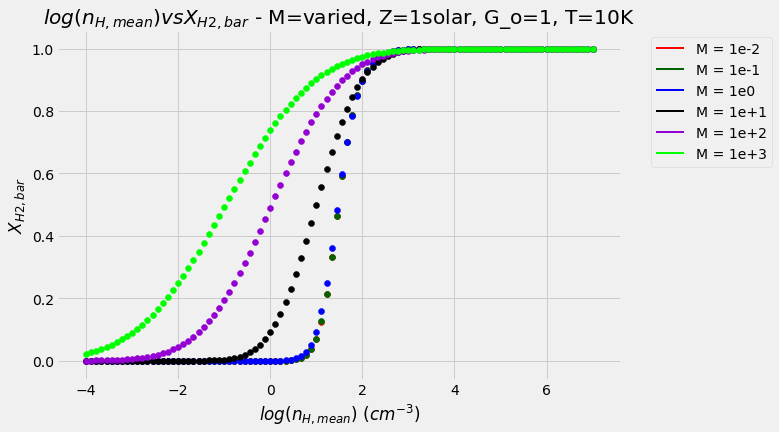

In [11]:
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 1
label = "M "
color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='darkgreen', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='darkviolet', lw=2),
                Line2D([0], [0], color='lime', lw=2)]
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-4, 7, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
l_CO_bar = np.zeros(len(n_H_mean_arr))
n_H2_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    color = str(color_arr[m])
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y], l_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            
            plt.scatter(np.log10(n_H_mean), X_H2_bar[y],
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.ylabel('$X_{H2, bar}$')
plt.xlabel('$log(n_{H, mean}) \ (cm^{-3})$')
# ax.set_ylim([0,0.5])
# ax.set_xlim([-4, 7])
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H, mean}) vs X_{H2, bar}$ - M=varied, Z=1solar, G_o=1, T=10K")
plt.show()


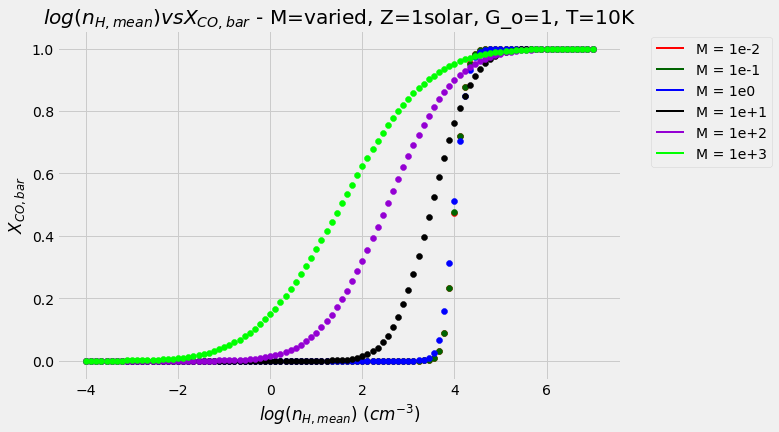

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 1
label = "M "
color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='darkgreen', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='darkviolet', lw=2),
                Line2D([0], [0], color='lime', lw=2)]
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-4, 7, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
l_CO_bar = np.zeros(len(n_H_mean_arr))
n_H2_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    color = str(color_arr[m])
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y], l_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            
            plt.scatter(np.log10(n_H_mean), X_CO_bar[y],
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.ylabel('$X_{CO, bar}$')
plt.xlabel('$log(n_{H, mean}) \ (cm^{-3})$')
# ax.set_ylim([0,0.5])
# ax.set_xlim([-4, 7])
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H, mean}) vs X_{CO, bar}$ - M=varied, Z=1solar, G_o=1, T=10K")
plt.show()
